In [81]:
import os
import toml
import torch
import xarray as xr
import numpy as np
from datetime import datetime as dt

import torch
from torch.utils.data import DataLoader
from torch.distributed.fsdp import ShardingStrategy
from torch.utils.data.distributed import DistributedSampler

from lightning.pytorch.callbacks import EarlyStopping
from lightning.fabric.loggers import CSVLogger
from lightning.fabric.strategies.fsdp import FSDPStrategy
from lightning.fabric.plugins.environments import MPIEnvironment

from torchmetrics.regression import MeanSquaredError

import Fires
from Fires._datasets.dataset_zarr import DatasetZarr, load_zarr
from Fires._datasets.torch_dataset import FireDataset
from Fires._macros.macros import (
	CONFIG,
	TORCH_CFG,
	DISCORD_CFG,
	CHECKPOINTS_DIR,
	DATA_DIR,
	LOG_DIR,
	NEW_DS_PATH,
	RUN_DIR,
	SCALER_DIR,
)

from Fires._scalers.scaling_maps import StandardMapsPointWise, MinMaxMapsPointWise
from Fires._scalers.standard import StandardScaler
from Fires._scalers.minmax import MinMaxScaler
from Fires._utilities.callbacks import DiscordBenchmark, FabricBenchmark, FabricCheckpoint
from Fires._utilities.cli_args_checker import checker
from Fires._utilities.configuration import load_global_config

from Fires.trainer import FabricTrainer

In [69]:
features = CONFIG.data.configs.config_fcci
drivers = features[:-1]
targets = [features[-1]]

In [121]:
max_hectares = pow((111),2)*100
max_hectares

1232100

In [122]:
zarr_ds = xr.open_zarr("./data/seasfire_v03_100km.zarr")[features].load()
zarr_ds['fcci_ba'] = zarr_ds['fcci_ba'] / max_hectares
zarr_ds

<xarray.Dataset>
Dimensions:    (time: 966, latitude: 180, longitude: 360)
Coordinates:
  * latitude   (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time       (time) datetime64[ns] 2001-01-01 2001-01-09 ... 2021-12-27
Data variables:
    lai        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    lst_day    (time, latitude, longitude) float32 nan nan nan ... 242.1 242.0
    rel_hum    (time, latitude, longitude) float32 76.84 76.92 ... 73.06 73.01
    ssr        (time, latitude, longitude) float32 -5.588e-15 ... 5.81
    sst        (time, latitude, longitude) float32 271.5 271.5 271.5 ... nan nan
    t2m_min    (time, latitude, longitude) float32 245.5 245.5 ... 245.5 245.5
    tp         (time, latitude, longitude) float32 0.2694 0.2612 ... 1.91 1.841
    lsm        (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    fcci_ba    (time, latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    crs:          EPSG:4326
    description:  The SeasFire Cube is a scientific datacube for seasonal fir...
    title:        SeasFire Cube: A Global Dataset for Seasonal Fire Modeling ...

In [ ]:
zarr_drv = zarr_ds[drivers]
zarr_trg = zarr_ds[targets]

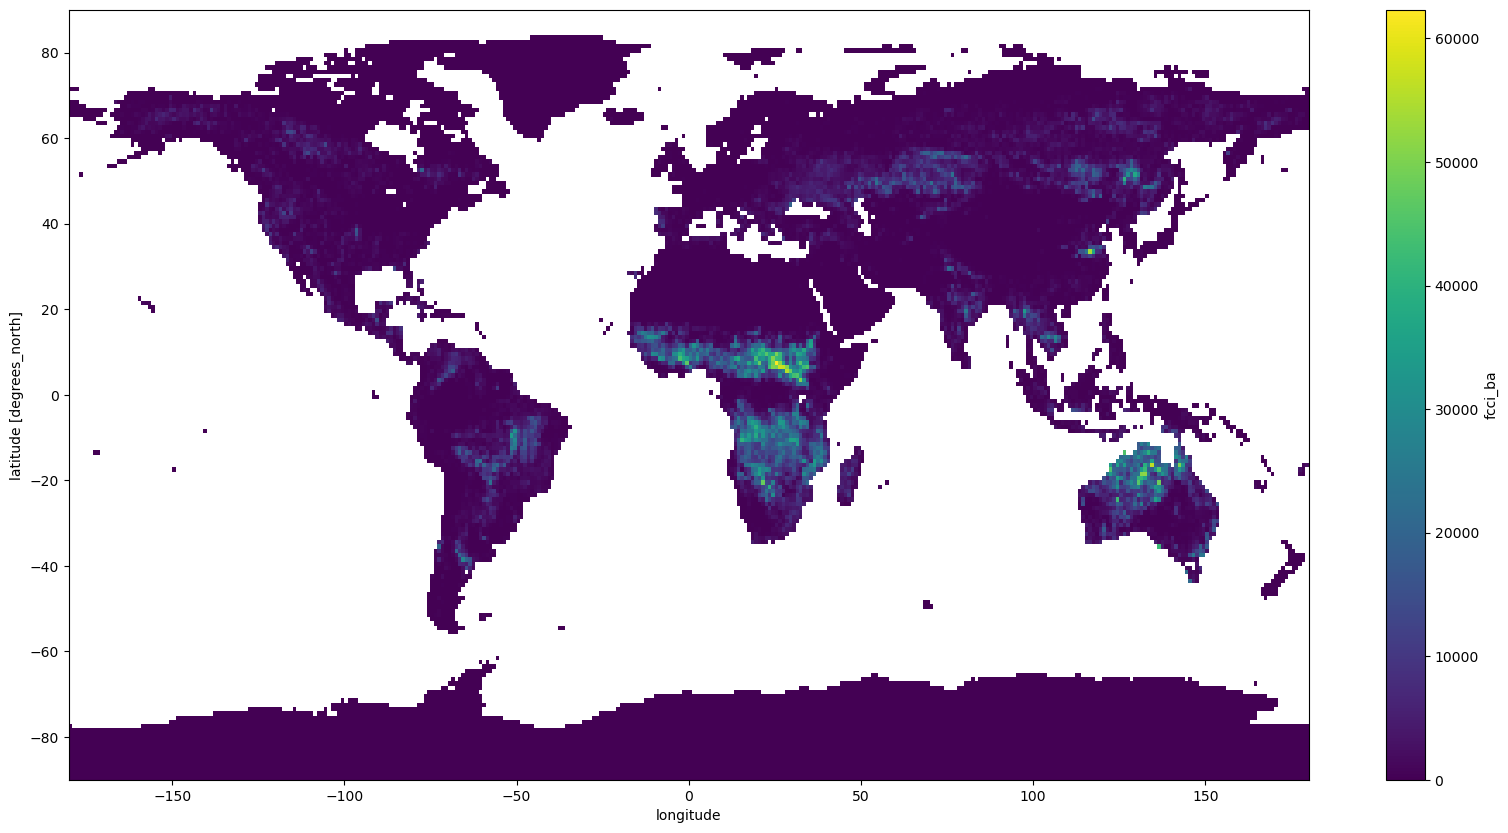

In [107]:
max_ds = zarr_trg.max(dim='time', skipna=True)
max_ds['fcci_ba'].plot(figsize=(20,10))

In [71]:
trn_years = list(range(2001, 2017))
val_years = list(range(2017, 2019))
tst_years = list(range(2019, 2021))

In [72]:
# load train, val and test ds
zarr_ds_trn = zarr_ds.sel(time=zarr_ds.time.dt.year.isin(trn_years))
zarr_ds_val = zarr_ds.sel(time=zarr_ds.time.dt.year.isin(val_years))
zarr_ds_tst = zarr_ds.sel(time=zarr_ds.time.dt.year.isin(tst_years))


In [73]:
# create point mean and standard deviation
mean_ds = zarr_ds_trn.mean(dim=['time','latitude', 'longitude'], skipna=True) #.to_array().values
stdv_ds = zarr_ds_trn.std(dim=['time','latitude', 'longitude'], skipna=True) #.to_array().values

# np.save("./data/scaler/mean100", mean_trn)
# np.save("./data/scaler/stdv100", stdv_trn)

In [74]:
# define scaler
x_scaler = StandardScaler(mean_ds=mean_ds, stdv_ds=stdv_ds, features=drivers)

# torch dataset
path100km = os.path.join(DATA_DIR, 'seasfire_v03_100km.zarr')
fire_ds_args = dict(src=None, drivers=drivers, targets=targets)
if os.path.exists(path100km):
	fire_ds_args['src']=path100km

# define pytorch datasets for training and validation
trn_torch_ds = FireDataset(**fire_ds_args, years=trn_years, scalers=[x_scaler, None])
val_torch_ds = FireDataset(**fire_ds_args, years=val_years, scalers=[x_scaler, None])

In [96]:
for x in trn_torch_ds:
	a, b = x
	print(a.shape)
	print(b.shape)
	break

torch.Size([8, 180, 360])
torch.Size([1, 180, 360])


In [78]:
# set pytorch configuration file
TORCH_CFG = load_global_config(config_fname=CONFIG.toml.torch_fname)
TORCH_CFG

Munch({'base': Munch({'cuda_availability': 'torch.cuda.is_available()', 'accelerator': 'cuda', 'matmul_precision': 'medium'}), 'model': Munch({'strategy': 'FSDPStrategy(sharding_strategy=ShardingStrategy.NO_SHARD)', 'loss': 'torch.nn.BCELoss()', 'metrics': '[]', 'dir': Munch({'RUN_DIR': 'os.path.join(EXPERIMENTS_DIR, _today)', 'CHECKPOINTS_DIR': "os.path.join(RUN_DIR, 'checkpoints')", 'SKIP_DAYS_DIRNAME': 'skip_days_00'}), 'unetpp': Munch({'cls': 'Fires._models.unetpp.UnetPlusPlus', 'args': Munch({'input_shape': [720, 1440, 8], 'num_classes': 1, 'depth': 4, 'base_filter_dim': 64, 'deep_supervision': False})}), 'earthformer': Munch({'cls': 'Fires._models.pangu.EarthTransformer3D', 'args': Munch({'in_channels': 8, 'out_channels': 1, 'shape': [720, 1440], 'patch_size': 4, 'win_size': 6, 'depth': [2, 5], 'heads': [5, 10], 'attention_dim': 32, 'num_wins': 'None', 'activation': 'torch.nn.ReLU()'})}), 'swintransformer': Munch({'cls': 'Fires._models.swin_transformer.SwinTransformerEarth2D', 'a

In [84]:
# check GPUs availability
cuda_availability:bool = eval(TORCH_CFG.base.cuda_availability)
print(f"CUDA available: {cuda_availability}")

# set device type
device:str = 'cuda' if cuda_availability else 'cpu'
print(f"Device: {device.upper()}")

# set matricial multiplication precision
if cuda_availability: torch.set_float32_matmul_precision(TORCH_CFG.base.matmul_precision)

# set accelerator
accelerator:str = 'cuda' if cuda_availability else 'cpu'
print(f"Accelerator: {accelerator.upper()}")

# define trainer accumulation steps
accumulation_steps = TORCH_CFG.trainer.accumulation_steps
print(f"Accumulation steps: {accumulation_steps}")

# define callbacks
callbacks = [
	DiscordBenchmark(webhook_url=DISCORD_CFG.hooks.webhook_gen, benchmark_csv=os.path.join(RUN_DIR, "fabric_benchmark.csv")),
	FabricBenchmark(filename=os.path.join(RUN_DIR, "fabric_benchmark.csv")),
	FabricCheckpoint(dst=CHECKPOINTS_DIR),
	EarlyStopping('val_loss')
]	
print(f"Callbacks: {callbacks}")

# define number of devices (GPUs) that must be used
devices = TORCH_CFG.trainer.devices
print(f"Devices: {devices}")

# define number of epochs
epochs = TORCH_CFG.trainer.epochs
print(f"Epochs: {epochs}")

# define today's date
today = eval(CONFIG.utils.datetime.today)
print(f"Today: {today}")

# define csv log name
csv_fname = f'{today}_csv_logs'
print(f"CSV Filename: {csv_fname}")

# define csv logger
loggers = CSVLogger(root_dir=LOG_DIR, name=csv_fname)
print(f"Loggers: {loggers}")

# define number of nodes used on the cluster
num_nodes = TORCH_CFG.trainer.num_nodes
print(f"Number of nodes: {num_nodes}")

# define trainer precision
precision = TORCH_CFG.trainer.precision
print(f"Precision: {precision}")

# define MPI plugin
plugins = eval(TORCH_CFG.trainer.plugins)
print(f"MPI plugin: {plugins}")

# init distribution strategy
strategy = eval(TORCH_CFG.model.strategy) if accelerator == 'cuda' else 'auto'
print(f"Strategy: {strategy}")

# set distributed sampler
use_distributed_sampler = eval(TORCH_CFG.trainer.use_distributed_sampler)
print(f"Use distributed sampler: {use_distributed_sampler}")

CUDA available: False
Device: CPU
Accelerator: CPU
Accumulation steps: 1
Callbacks: [<Fires._utilities.callbacks.DiscordBenchmark object at 0x1507d3750>, <Fires._utilities.callbacks.FabricBenchmark object at 0x152284f90>, <Fires._utilities.callbacks.FabricCheckpoint object at 0x152285590>, <lightning.pytorch.callbacks.early_stopping.EarlyStopping object at 0x152286090>]
Devices: 2
Epochs: 75
Today: 20240708_131103
CSV Filename: 20240708_131103_csv_logs
Loggers: <lightning.fabric.loggers.csv_logs.CSVLogger object at 0x137a0d410>
Number of nodes: 4
Precision: 32-true
MPI plugin: [<lightning.fabric.plugins.environments.mpi.MPIEnvironment object at 0x150715410>]
Strategy: ddp_notebook
Use distributed sampler: False


In [85]:
# initialize trainer and its arguments
trainer = FabricTrainer(
	accelerator=accelerator,
	callbacks=callbacks,
	devices=devices,
	loggers=loggers,
	max_epochs=epochs,
	num_nodes=num_nodes,
	grad_accum_steps=accumulation_steps,
	precision=precision,
	plugins=plugins,
	strategy=strategy,
	use_distributed_sampler=use_distributed_sampler
)

TypeError: To spawn processes with the `DDPStrategy` strategy, `.launch()` needs to be called with a function that contains the code to launch in processes.